<a href="https://colab.research.google.com/github/eduardoansi/mkt_study/blob/master/Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data exploration

Given the small size of the file I decided to use Pandas to import the csv and explore the data, and later on import the dataset into a SQL-Lite temporary database for further analysis.

In [1]:
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/iFood/ml_project1_data.csv')
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
df.set_index('ID', inplace=True)

In [2]:
df.dtypes

Year_Birth                      int64
Education                      object
Marital_Status                 object
Income                        float64
Kidhome                         int64
Teenhome                        int64
Dt_Customer            datetime64[ns]
Recency                         int64
MntWines                        int64
MntFruits                       int64
MntMeatProducts                 int64
MntFishProducts                 int64
MntSweetProducts                int64
MntGoldProds                    int64
NumDealsPurchases               int64
NumWebPurchases                 int64
NumCatalogPurchases             int64
NumStorePurchases               int64
NumWebVisitsMonth               int64
AcceptedCmp3                    int64
AcceptedCmp4                    int64
AcceptedCmp5                    int64
AcceptedCmp1                    int64
AcceptedCmp2                    int64
Complain                        int64
Z_CostContact                   int64
Z_Revenue   

It is important to convert categorical variables into numeric values to be later used to create the prediction models. This is the case with the features Education and Marital_Status.

I will also create columns to store the age of the applicants, as well as the number of days since they became costumers for this business.

In [3]:
# Check unique Marital_Status values

print(df['Marital_Status'].value_counts())

# Check unique Education values

print(df['Education'].value_counts())

Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64
Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: Education, dtype: int64


In [4]:
# Create columns to store Marital_Status information with boolean values

df['Marital_Married'] = df['Marital_Status'].apply(lambda x: True if x == 'Married' else False)
df['Marital_Together'] = df['Marital_Status'].apply(lambda x: True if x == 'Together' else False)
df['Marital_Single'] = df['Marital_Status'].apply(lambda x: True if x == 'Single' else False)
df['Marital_Divorced'] = df['Marital_Status'].apply(lambda x: True if x == 'Divorced' else False)
df['Marital_Widow'] = df['Marital_Status'].apply(lambda x: True if x == 'Widow' else False)
df['Marital_Other'] = df['Marital_Status'].apply(lambda x: True if x == 'Alone' or x == 'YOLO' or x == 'Absurd' else False)

# Create columns to store Education information with boolean values

df['Education_Graduation'] = df['Education'].apply(lambda x: True if x == 'Graduation' else False)
df['Education_PhD'] = df['Education'].apply(lambda x: True if x == 'PhD' else False)
df['Education_Master'] = df['Education'].apply(lambda x: True if x == 'Master' else False)
df['Education_2ndCycle'] = df['Education'].apply(lambda x: True if x == '2n Cycle' else False)
df['Education_Basic'] = df['Education'].apply(lambda x: True if x == 'Basic' else False)

To calculate the variables using datetime, it is useful to have a reference point as to when the study is being done in order to have a more reasonable analysis.

This is done by adding the Recency and Dt_Customer features and taking the maximum value of this series. The result will express the latest possible date of a purchase by any consumer, and so 

In [5]:
# Find the reference date for the dataset

(df['Dt_Customer'] + pd.to_timedelta(df['Recency'], unit='days')).max()

Timestamp('2014-10-04 00:00:00')

In [6]:
# Checking the rows with this result

df[(df['Dt_Customer'] + pd.to_timedelta(df['Recency'], unit='days')) == pd.to_datetime('2014-10-04')][['Dt_Customer','Recency']]

,Dt_Customer,Recency
ID,,
6722,2014-06-28,98
2831,2014-06-27,99


The maximum date for when the dataset was created is, therefore, 2014-oct-04. This date will be used to calculate the additional columns.

In [7]:
# Calculating Age column

df['Age'] = 2014 - df['Year_Birth']

# Calculating the period, in days, since the individual is a customer of the company

df['PeriodAsCustomer'] = (pd.to_datetime('2014-12-31') - df['Dt_Customer']).dt.days.astype('int64')

# Droping columns that won't be used any longer

df.drop(['Year_Birth','Education','Marital_Status','Dt_Customer'], axis=1, inplace=True)

In [8]:
# Checking if the dataframe looks correct

df.head(5)

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Marital_Married,Marital_Together,Marital_Single,Marital_Divorced,Marital_Widow,Marital_Other,Education_Graduation,Education_PhD,Education_Master,Education_2ndCycle,Education_Basic,Age,PeriodAsCustomer
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5524,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,False,False,True,False,False,False,True,False,False,False,False,57,848
2174,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,False,False,True,False,False,False,True,False,False,False,False,60,298
4141,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,False,True,False,False,False,False,True,False,False,False,False,49,497
6182,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,False,True,False,False,False,False,True,False,False,False,False,30,324
5324,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,True,False,False,False,False,False,False,True,False,False,False,33,346


In [9]:
# Describe data for a statistical overview

df.describe()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age,PeriodAsCustomer
count,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000,2240.000000,2240.000000
mean,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107,45.194196,538.582143
std,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274,11.984069,202.122512
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,18.000000,185.000000
25%,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,37.000000,365.750000
50%,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,44.000000,540.500000
75%,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,55.000000,714.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000,121.000000,884.000000


In [10]:
# Because Cost and Revenue for individual are constant values, we can exclude them from the dataframe and assign them to normal variables

CostContact = 3
RevenueContact = 11

df.drop(['Z_CostContact', 'Z_Revenue'], axis=1, inplace=True)

# Double checking total cost and value for the last operation, as well as success rate

print('Cost value: ' + str(df['Response'].count() * CostContact) + 'MU')
print('Revenue value: ' + str(df[df['Response'] == 1]['Response'].count() * RevenueContact) + 'MU')
print('Sucess rate: ' + str(round(df[df['Response'] == 1]['Response'].count()*100/df['Response'].count(),1)) + '%')

Cost value: 6720MU
Revenue value: 3674MU
Sucess rate: 14.9%


In [11]:
df['Income'].sort_values(axis=0, ascending=False).head(10)

ID
9432     666666.0
1503     162397.0
1501     160803.0
5336     157733.0
8475     157243.0
4931     157146.0
11181    156924.0
5555     153924.0
4619     113734.0
4611     105471.0
Name: Income, dtype: float64

These calculations are done in order to check inconsistencies within the dataset. Most of the information seems correct and matches the values stated in the briefing file.

There seems to be one outlier in terms of the Income column. Not only the top value is very high compared to the next highest, it is also unusual for an income to be precisely 666666MU. While it is not possible to be sure if this register was filled correctly or not.

At the same time, this column Income is the only one that has missing values, suggesting that this was possibily an optional question when the gadget was offered during the call.

To investigate further this issue, I decided to evaluate some important data from the 24 rows with a missing value in the Income variable, as well as the outlier with a very high number.

In [12]:
df_income = df[(df['Income'].isna()) | (df['Income'] == 666666)].copy()
df_income.describe()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,PeriodAsCustomer
count,1.0,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.00000,25.000000,25.000000,25.000000,25.00000,25.00000,25.000000,25.0,25.000000,25.00,25.000000,25.0,25.0,25.00,25.000000,25.000000
mean,666666.0,0.680000,0.560000,56.640000,189.680000,21.040000,156.920000,26.400000,29.04000,47.760000,2.520000,4.000000,1.80000,4.72000,5.120000,0.0,0.120000,0.04,0.080000,0.0,0.0,0.04,46.160000,545.520000
std,NaN,0.627163,0.583095,29.709538,240.340335,37.532741,333.531972,40.593513,57.55467,78.279031,2.615977,5.196152,2.43242,3.12943,2.538372,0.0,0.331662,0.20,0.276887,0.0,0.0,0.20,11.922248,170.907899
min,666666.0,0.000000,0.000000,4.000000,5.000000,0.000000,3.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.0,0.00,25.000000,218.000000
25%,666666.0,0.000000,0.000000,25.000000,19.000000,1.000000,15.000000,2.000000,1.00000,7.000000,1.000000,1.000000,0.00000,3.00000,3.000000,0.0,0.000000,0.00,0.000000,0.0,0.0,0.00,37.000000,421.000000
50%,666666.0,1.000000,1.000000,57.000000,71.000000,4.000000,27.000000,8.000000,4.00000,17.000000,2.000000,3.000000,1.00000,4.00000,6.000000,0.0,0.000000,0.00,0.000000,0.0,0.0,0.00,44.000000,556.000000
75%,666666.0,1.000000,1.000000,82.000000,264.000000,20.000000,172.000000,38.000000,30.00000,53.000000,3.000000,5.000000,3.00000,7.00000,7.000000,0.0,0.000000,0.00,0.000000,0.0,0.0,0.00,56.000000,639.000000
max,666666.0,2.000000,2.000000,96.000000,861.000000,138.000000,1607.000000,164.000000,263.00000,362.000000,12.000000,27.000000,10.00000,12.00000,9.000000,0.0,1.000000,1.00,1.000000,0.0,0.0,1.00,71.000000,871.000000


In [13]:
df_income['Response'].count()/2240

0.011160714285714286

At a first glance there seems to be no issue with the rest of the data. Most of these individuals did not accept the offer, except for one. Now there is a decision to be made in terms of these missing values.

1.   Take the average of the column Income and assign to these rows;
2.   Exclude these rows from the dataset.

The first case is usually safe, but the mean of the column is around 52 thousand MU and the standard deviation is around 25 thousand MU. This shows that this sample, in terms of the income level, is quite heterogeneous. Assigning the average value to these users would cause a discrepancy of this characteristic, even if not by a big factor. However, later we will use the income level to create the prediction model and customers groups, as it is such an important variable to the study.

Therefore, I decided to exclude these 25 rows (24 with a missing income value and one outlier), representing 1.1% of the total sample, and proceed with the analysis.

In [14]:
# Filtering the dataframe

df = df[(df['Income'].notna()) & (df['Income'] != 666666)].copy()

In [15]:
df.describe()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,PeriodAsCustomer
count,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000
mean,51969.861400,0.441535,0.505643,49.024379,305.225282,26.361625,167.063205,37.651016,27.040632,43.979684,2.322799,4.085779,2.671783,5.802257,5.318736,0.073589,0.074041,0.073138,0.064108,0.013544,0.009481,0.150339,45.183296,538.503837
std,21526.320095,0.536886,0.544198,28.949608,337.345380,39.802036,224.311559,54.760822,41.077594,51.822660,1.923820,2.741473,2.927179,3.250974,2.425863,0.261160,0.261896,0.260421,0.245001,0.115614,0.096929,0.357484,11.987000,202.478727
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,185.000000
25%,35284.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.000000,365.000000
50%,51373.000000,0.000000,0.000000,49.000000,175.000000,8.000000,68.000000,12.000000,8.000000,25.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44.000000,540.000000
75%,68487.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.500000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.000000,714.000000
max,162397.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,121.000000,884.000000


# Consumer profiling and prediction

In [16]:
# Calculating correlation values

df_corr = df.corr()\
            .loc[['Response']]\
            .T

df_corr\
  .sort_values(ascending=False, by='Response')\
  .where(abs(df.corr()) > 0.1)\
  .dropna()\
  .iloc[1:]\
  .style.bar(align='zero', color=['#ff3366', '#33ff99'])\
  .set_properties(**{'background-color': 'silver', 'color': 'black', 'text-align': 'center'})

,Response
AcceptedCmp5,0.323339
AcceptedCmp1,0.297312
AcceptedCmp3,0.253966
MntWines,0.246185
MntMeatProducts,0.237653
NumCatalogPurchases,0.219830
PeriodAsCustomer,0.196525
AcceptedCmp4,0.180162
AcceptedCmp2,0.169279
Income,0.161049


This table is quite informative. First of all, it is clear that the Response feature does not have a strong positive or negative correlation with any other variable. This was already expected given the success rate of only 15% stated initially in the project.

We notice that the response rate is positively correlated to the features that describe the acceptance of previous campaigns, suggesting that customers that purchased gadgets of offers before might be more inclined to do it again. While correlation should not be mistaken with cause, it is still a pattern that should be further explored.

Other relevant correlated features include customers that: 

*   consume higher quantities of products, especially meat and wine;
*   are used to buying from the catalog;
*   have a wider period of purchasing history;
*   have higher income.

It can be noted that the highest absolute negative correlation of the Response feature is with the variable Recency, which can indicate that customers with more recent purchases are more likely to be interested in buying the gadget. This can happen because their recent purchase experience might be still 'fresh' and their inclination towards aquiring the campaign offer is stronger than from customers with a bigger gap between their last consumption and the call. Another possibility is that not recent customers are more unlikely to have accepted the offer as they might have switched preferences or conditions.

Having teenagers at home is also negatively correlated, perhaps being another relevant feature for the targeted customer profile.

### Prediction hypothesis

These insights enable the formulation of a general hypothesis for the prediction model.

The success rate of the current offer should increase if the customer group focused during the campaign has these characteristics:

*   Customers that have purchased previous offers;
*   Customers with higher volume of purchased goods;
*   Customers with a more recent purchasing activity;
*   Customers that are more likely to consume from catalog;
*   Customers with higher income;
*   Customers with a longer history with the company;
*   Customers without teenagers at home.

The machine learning model will evaluate if these features are indeed the best to describe the focus group for the campaign.

### Machine Learning methodology

For this particular dataset, I decided to have customers separated in clusters, and to do so I chose to use the K-Means algorithm, which is a good general purpose methodology.

These are the steps to be followed:

1.   Normalize data
2.   Calculate optimal number of clusters
3.   Visualize the clusters
4.   Conclude the customer classification model

#### Normalize data

While it is possible to run the K-Means algorithm on the data as it is, this methodology works better when the data is normalized, meaning that all values are represented on the same scale, so we can avoid a biased prediction.

In [17]:
# Import StandardScaler

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_df_array = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df_array, columns=df.columns, index=df.index)

In [18]:
scaled_df.head(5)

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Marital_Married,Marital_Together,Marital_Single,Marital_Divorced,Marital_Widow,Marital_Other,Education_Graduation,Education_PhD,Education_Master,Education_2ndCycle,Education_Basic,Age,PeriodAsCustomer
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5524,0.286604,-0.822585,-0.929363,0.310113,0.977779,1.548973,1.689714,2.453932,1.484340,0.849633,0.352088,1.428103,2.504074,-0.554500,0.693215,-0.281842,-0.282774,-0.280907,-0.261725,-0.117175,-0.097834,2.377320,-0.794402,-0.590037,1.924256,-0.342045,-0.188496,-0.056305,0.993251,-0.526681,-0.444182,-0.315049,-0.158077,0.986016,1.528882
2174,-0.261407,1.040427,0.908618,-0.380899,-0.872375,-0.637338,-0.718196,-0.651178,-0.634081,-0.733043,-0.167829,-1.125846,-0.571253,-1.169839,-0.131420,-0.281842,-0.282774,-0.280907,-0.261725,-0.117175,-0.097834,-0.420642,-0.794402,-0.590037,1.924256,-0.342045,-0.188496,-0.056305,0.993251,-0.526681,-0.444182,-0.315049,-0.158077,1.236344,-1.188066
4141,0.912723,-0.822585,-0.929363,-0.795506,0.358096,0.568903,-0.178646,1.339745,-0.147087,-0.038210,-0.687745,1.428103,-0.229550,1.291518,-0.543738,-0.281842,-0.282774,-0.280907,-0.261725,-0.117175,-0.097834,-0.420642,-0.794402,1.694809,-0.519681,-0.342045,-0.188496,-0.056305,0.993251,-0.526681,-0.444182,-0.315049,-0.158077,0.318476,-0.205025
6182,-1.176680,1.040427,-0.929363,-0.795506,-0.872375,-0.561948,-0.655768,-0.505056,-0.585381,-0.752344,-0.167829,-0.760996,-0.912956,-0.554500,0.280897,-0.281842,-0.282774,-0.280907,-0.261725,-0.117175,-0.097834,-0.420642,-0.794402,1.694809,-0.519681,-0.342045,-0.188496,-0.056305,0.993251,-0.526681,-0.444182,-0.315049,-0.158077,-1.266933,-1.059629
5324,0.293806,1.040427,-0.929363,1.553934,-0.392047,0.418123,-0.218777,0.152497,-0.000989,-0.559335,1.391921,0.333553,0.112153,0.060839,-0.131420,-0.281842,-0.282774,-0.280907,-0.261725,-0.117175,-0.097834,-0.420642,1.258808,-0.590037,-0.519681,-0.342045,-0.188496,-0.056305,-1.006795,1.898681,-0.444182,-0.315049,-0.158077,-1.016605,-0.950951


#### Calculate optimal number of clusters

Initially the method used for selecting the optimal number of clusters was the Elbow Method. It consists in plotting the sum of squared distances do closest cluster center (SSE) per each value of 'k', 'k' being the number of clusters. Usually the 'SSE' value decreases when 'k' increases.

While it is important to have a low 'SSE' value, separating the data into too many clusters weakens the prediction model. That is why it is often a good idea to pick the 'k' value where there is an inflection point in chart, meaning that we don't select a number of clusters with only marginal improvements on 'SSE'.

In [19]:
# Import KMeans

from sklearn.cluster import KMeans

# Import plotting libraries

import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


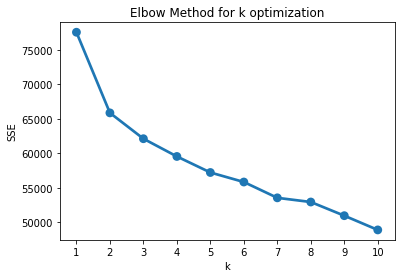

In [20]:
# Calculating the ideal number of clusters based on the Elbow Method

sse = {}

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(scaled_df)
    sse[k] = kmeans.inertia_
    
# Plot SSE for each k

plt.title('Elbow Method for k optimization')
plt.xlabel('k')
plt.ylabel('SSE') 
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

There is not a very clear and strong inflection point in this chart, but the best guess would probably be when k = 2. This can make sense because ultimately we have customers that bought the gadget and customers that didn't. However, while this will be considered as a real possibility, the main goal of this project is to find the best way to maximize profit. This means that maybe a more restricted group but with higher probability of having a positive response to the campaign can yield more profit.

Within any cluster, if we take the mean of the response feature we will get the proportion of individuals that purchased the gadget. We can then calculate the total revenue generated by this particular group and subtract by the campaign cost for the entire cluster.

The next step is to iterate over different values of k and save the relevant information into a separate dataframe, where we will perform our profitability analysis and predict the results for the entire customer base. 

In [21]:
k_list = []

for k in range(1, 11):
  kmeans = KMeans(n_clusters=k, random_state=1)
  kmeans.fit(scaled_df)
  df_k = df.assign(cluster = kmeans.labels_)

  for i in range(k):
    avg = df_k[df_k['cluster'] == i]['Response'].mean()
    cnt = df_k[df_k['cluster'] == i]['Response'].count()
    k_lst = [k, i, avg, cnt]
    k_list.append(k_lst)

k_results = pd.DataFrame(k_list, columns=['k', 'Cluster_Number', 'Response_Mean', 'Response_Count'])

k_results.head(5)

,k,Cluster_Number,Response_Mean,Response_Count
0,1,0,0.150339,2215
1,2,0,0.234624,878
2,2,1,0.094989,1337
3,3,0,0.112481,649
4,3,1,0.093750,1024


In [22]:
# Calculating profitability stats for each case

sample_size = df.shape[0]

k_results['Response_Sample_Pct'] = k_results['Response_Count'] / sample_size
k_results['Contact_Revenue'] = k_results['Response_Count'] * k_results['Response_Mean'] * RevenueContact
k_results['Contact_Cost'] = k_results['Response_Count'] * CostContact
k_results['Total_Profit'] = k_results['Contact_Revenue'] - k_results['Contact_Cost']
k_results['Profit_Rate'] = k_results['Total_Profit'] / k_results['Contact_Revenue']

k_results.sort_values('Total_Profit', ascending=False).where(k_results['Total_Profit'] > 0).dropna()

,k,Cluster_Number,Response_Mean,Response_Count,Response_Sample_Pct,Contact_Revenue,Contact_Cost,Total_Profit,Profit_Rate
30,8.0,2.0,0.611111,162.0,0.073138,1089.0,486.0,603.0,0.553719
7,4.0,1.0,0.579882,169.0,0.076298,1078.0,507.0,571.0,0.529685
14,5.0,4.0,0.576471,170.0,0.076749,1078.0,510.0,568.0,0.526902
44,9.0,8.0,0.492228,193.0,0.087133,1045.0,579.0,466.0,0.445933
24,7.0,3.0,0.487047,193.0,0.087133,1034.0,579.0,455.0,0.440039
18,6.0,3.0,0.487047,193.0,0.087133,1034.0,579.0,455.0,0.440039
53,10.0,8.0,0.489474,190.0,0.085779,1023.0,570.0,453.0,0.442815
37,9.0,1.0,0.450450,111.0,0.050113,550.0,333.0,217.0,0.394545
46,10.0,1.0,0.445455,110.0,0.049661,539.0,330.0,209.0,0.387755
5,3.0,2.0,0.302583,542.0,0.244695,1804.0,1626.0,178.0,0.098670


This table shows that dividing the customers into 8 clusters will create an optimal sub-group in terms of profitability. Comparing this result with the Elbow Method, it produces a different interpretation, but one that can be explained by considering the reasonably high number of features for the sample size.

I decide to segment the dataset into **8 clusters** for the prediction model, having an improved profitability as the main argument.

#### Visualize the clusters

In [23]:
# Running again the algorithm with 8 clusters

kmeans = KMeans(n_clusters=8, random_state=1)
kmeans.fit(scaled_df)

cluster_labels = kmeans.labels_

# Assigning cluster labels to the dataset
df_k8 = scaled_df.assign(cluster = cluster_labels)

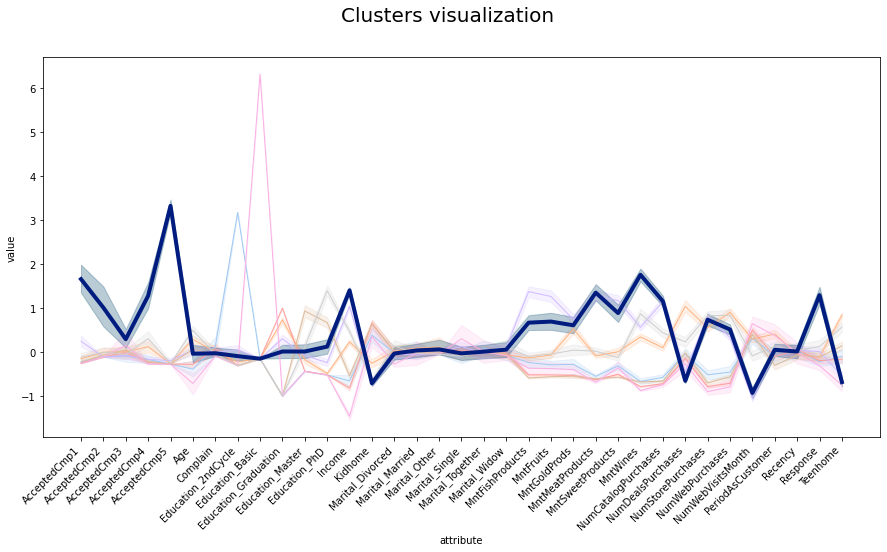

In [24]:
# Prepare dataframe for plotting

df_melt = pd.melt(
    df_k8.reset_index(), 
    id_vars=['ID', 'cluster'],
    value_vars=['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response', 'Marital_Married',
       'Marital_Together', 'Marital_Single', 'Marital_Divorced',
       'Marital_Widow', 'Marital_Other', 'Education_Graduation',
       'Education_PhD', 'Education_Master', 'Education_2ndCycle',
       'Education_Basic', 'Age', 'PeriodAsCustomer'],
    var_name='attribute',
    value_name='value'
    )

# Plotting clusters

fig = plt.figure(figsize=(15,7))
chart = sns.lineplot(
    x="attribute",
    y="value",
    hue='cluster',
    data=df_melt,
    linewidth=1,
    legend=False,
    palette='pastel'
    )

# Highlighting cluster number 2

k2 = sns.lineplot(
    x="attribute",
    y="value",
    hue='cluster',
    data=df_melt[df_melt['cluster'] == 2],
    linewidth=4,
    palette='dark',
    legend=False
    )

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium'
    )

fig.suptitle('Clusters visualization', fontsize=20)

plt.show()


Visually it is clear that the cluster 2, highlighted with a thick dark blue line, is the one with the highest value in the Response feature, while all the others seem to be very close to each other in this aspect.

It also shows that our assumptions based on the correlation analysis were also caught by the algorithm, like the positive values for the acceptance of previous offers, higher income level, higher purchase quantity of meat and wine products, among others.

#### Concluding the prediction model

With the available results it is possible to retrieve the classification method in order to apply. Using the method 'predict' of the K-Means algorithm on a dataframe will allocate each individual to one of the eight clusters defined by this model.

In order to do so, it is important to normalize the data before applying the prediction method.

In [25]:
## Considering an already clean and processed dataframe called 'df_complete' following the steps from the beginning in this notebook:

# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# scaled_df_complete_array = scaler.fit_transform(df_complete)
# scaled_df_complete = pd.DataFrame(scaled_df_complete_array, columns=df_complete.columns, index=df_complete.index)

## Predicting values

# y_kmeans = kmeans.predict(scaled_df_complete)

## Assigning predicted cluster values to the original dataframe

# df_complete['Cluster'] = y_means

To summarize the prediction model:

*   Selected K-Means algorithm to create clusters of customers;
*   Optimized focus group profitability using 8 clusters;
*   61% of the individuals in this cluster accepted the offer;
*   Profit generated was 603MU, against -3.046MU of the original sample;
*   Profit rate (profit/revenue) = 55%.



# Exporting data

The last step of this project is to produce a dashboard with the most relevant insights in order to present a viable way of moving forward with the marketing campaign. This will be done with Tableau, given its relative ease and flexibility to use and create appealing visuals.

I will export a CSV file containing the preprocessed with the an added column to assign a cluster value for each individual. The dataframe with profitability results for each 'k' value will also be exported in a separate file, as it might provide further possibilities of presentation, as well as other complementary results found on this study.

In [26]:
# Export files to csv

df_k.to_csv('customers_processed.csv')
k_results.to_csv('cluster_results.csv', index=False)
df_corr.to_csv('correlation_response.csv')
df_melt.to_csv('cluster_plot.csv')

# Dashboard



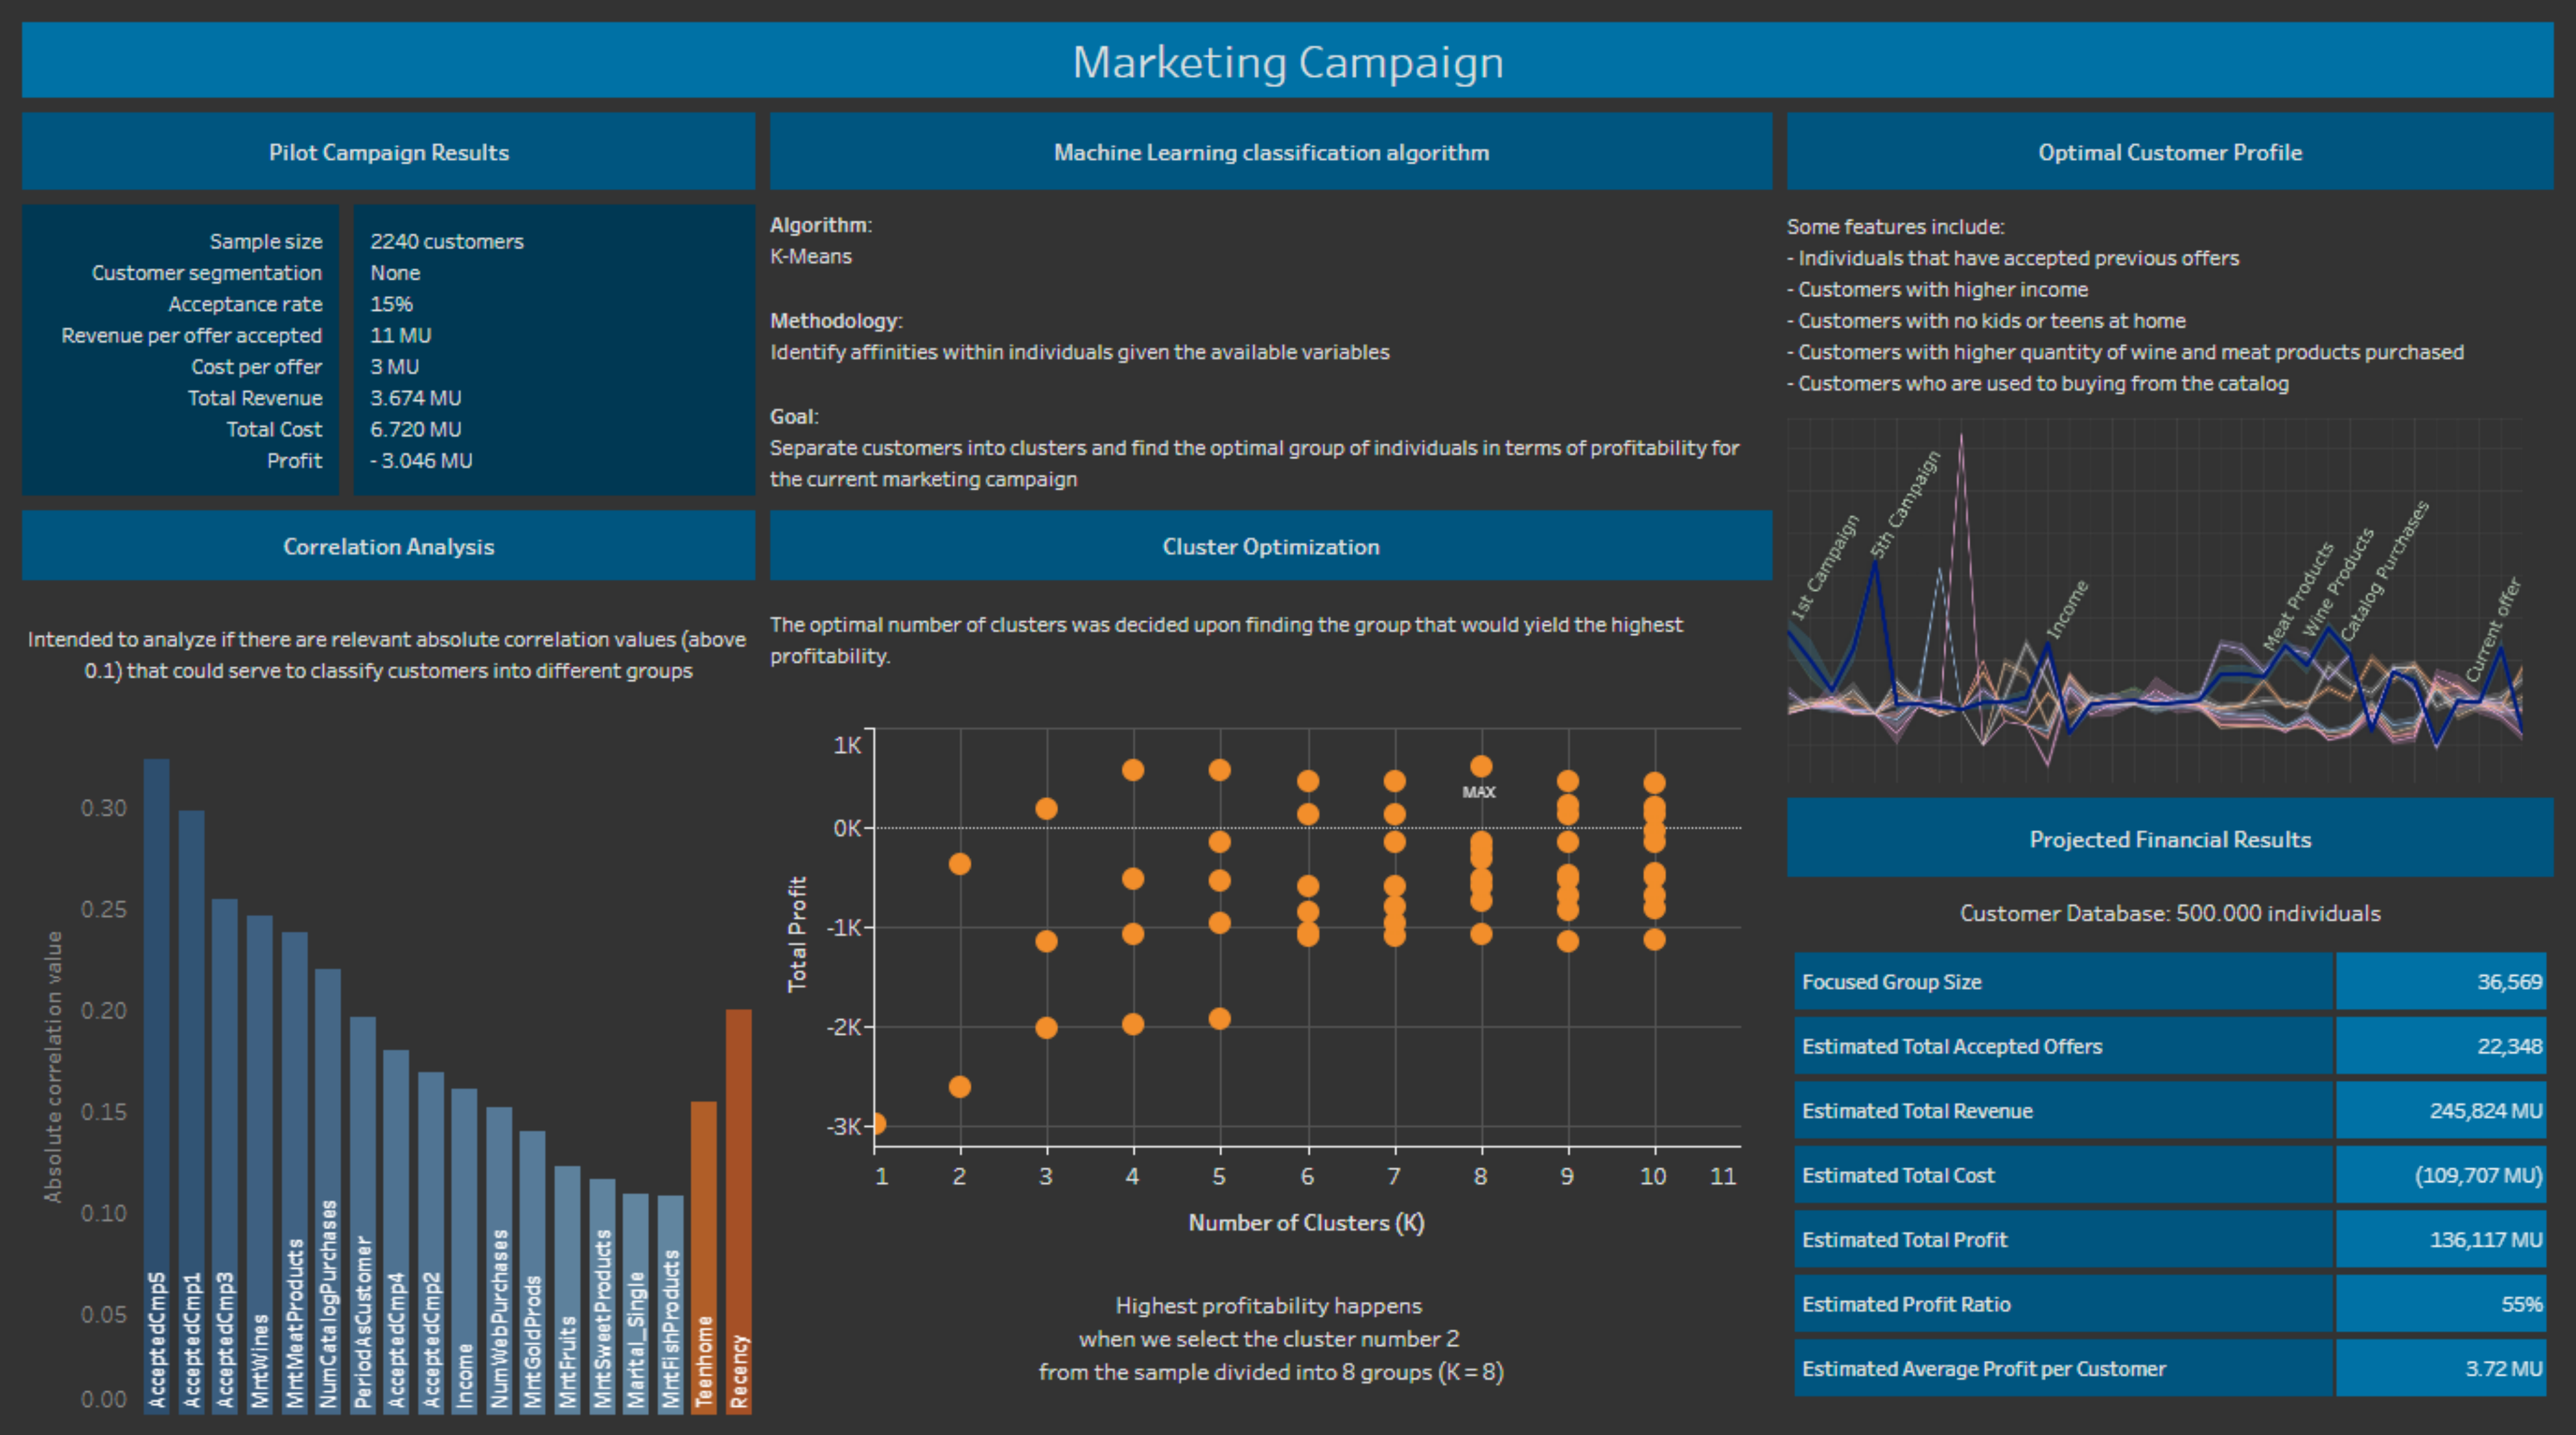